# Import necessary python packages

In [1]:
import os

import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
import py3Dmol

from importlib_resources import files

# Load packages from silc

In [2]:
import silc.util as util
from silc.force_field import gaff2

# Calculate partial charge for the binding motif

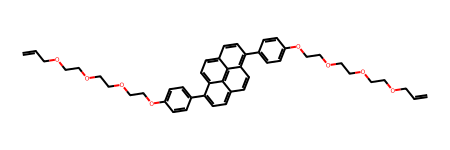

In [3]:
nEO = 3
motif_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "Oc6ccc(c2ccc3ccc5c(c1ccc(O" + "CCO"*nEO + "CC=C)cc1)ccc4ccc2c3c45)cc6"
AllChem.MolFromSmiles(motif_smiles(nEO))

We can obtain the partial charge by two methods
1. Calculate the partial charge for the whole molecule, which could be very slow for large molecules (such as ditopic molecules);
2. Calculate the partial charge for molecular fragments, then combine the fragment partial charges together.

## Method 1: from the whole molecule

In [4]:
numConfs = 5
chg = gaff2.charge(read_only=True)    # set read_only = False for new molecules
chg.set_work_path(files('silc.data.tutorial').joinpath("amber_charge"))    # set the work_path
chg.set_molecule_from_smile(motif_smiles(nEO))
chg.set_num_confs(numConfs)
chg.run()
#chf = chg.write_charge(file_name="partial_charge.txt")

Plot the distribution of conformer partial charge

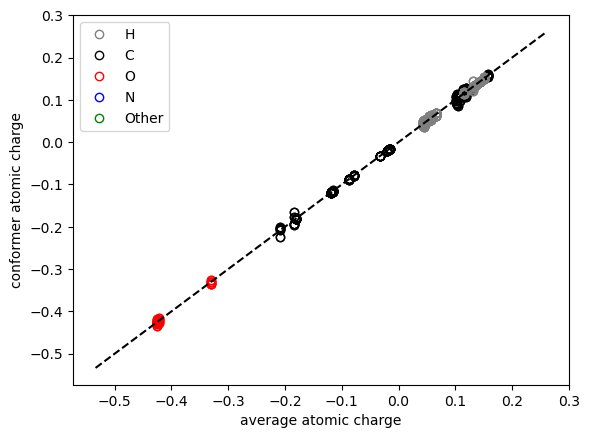

In [5]:
chg.plot_charge()

Show multiple conformers used for partial charge calculation

In [6]:
diphenylpyrene = "c6ccc(c2ccc3ccc5c(c1ccccc1)ccc4ccc2c3c45)cc6"

core = util.gen_mol_from_smiles(diphenylpyrene)
match = chg.mol.GetSubstructMatch(core)
AllChem.AlignMolConformers(chg.mol, atomIds=match)
viewer = py3Dmol.view(width=500, height=500)
colors = ['red', 'orange', 'green', 'blue', 'purple']
for cid in range(numConfs):
    conf = chg.mol.GetConformer(cid)
    motif_block = AllChem.MolToMolBlock(chg.mol, confId=cid)
    viewer.addModel(motif_block, 'mol')
    viewer.setStyle({'model':cid,}, {'stick': {'color':colors[cid]}})
viewer.zoomTo()
viewer.show()

[00:54:55] Molecule does not have explicit Hs. Consider calling AddHs()
[00:54:55] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Average partial charge from all conformers

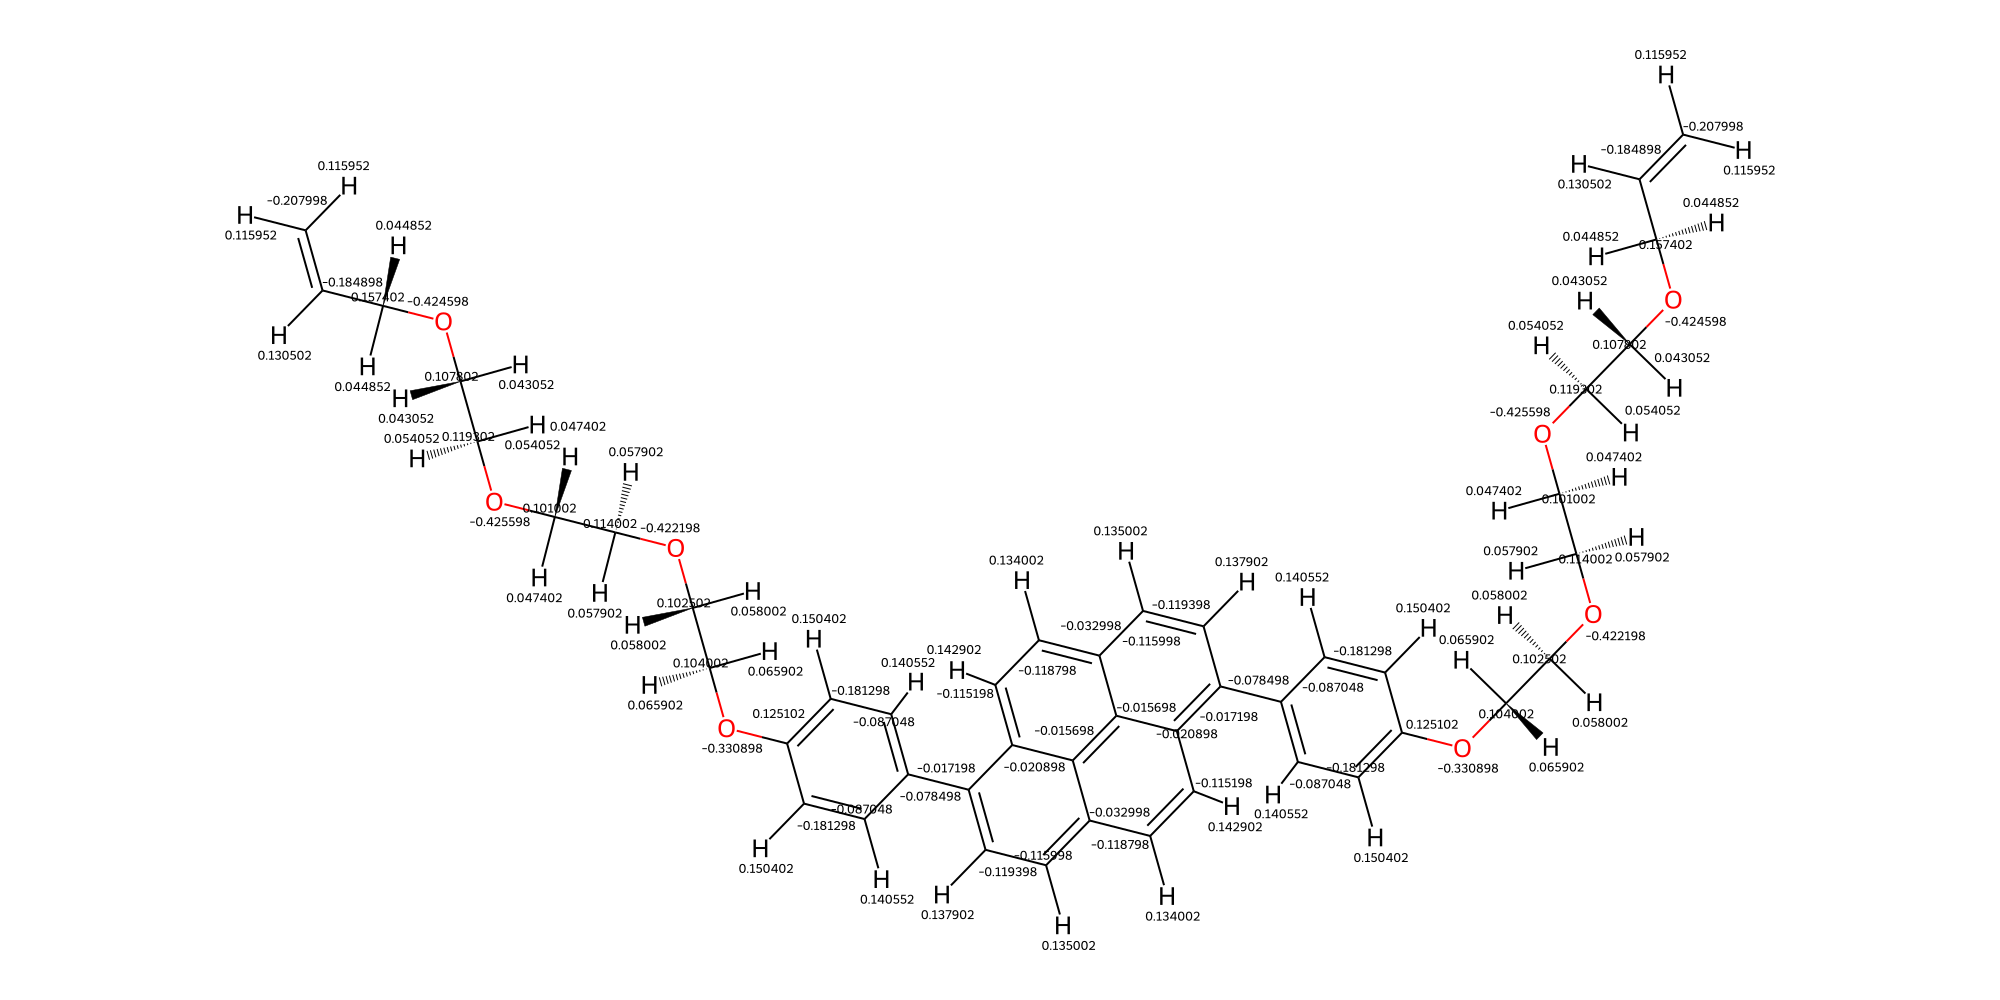

In [7]:
chg.draw_mol_with_charge(image_size=(2000, 1000))

## Method 2: from molecular fragments (tails, cores and bridges)

Load partial charge calculated from molecular fragments

[00:54:55] WARNING: More than one matching pattern found - picking one



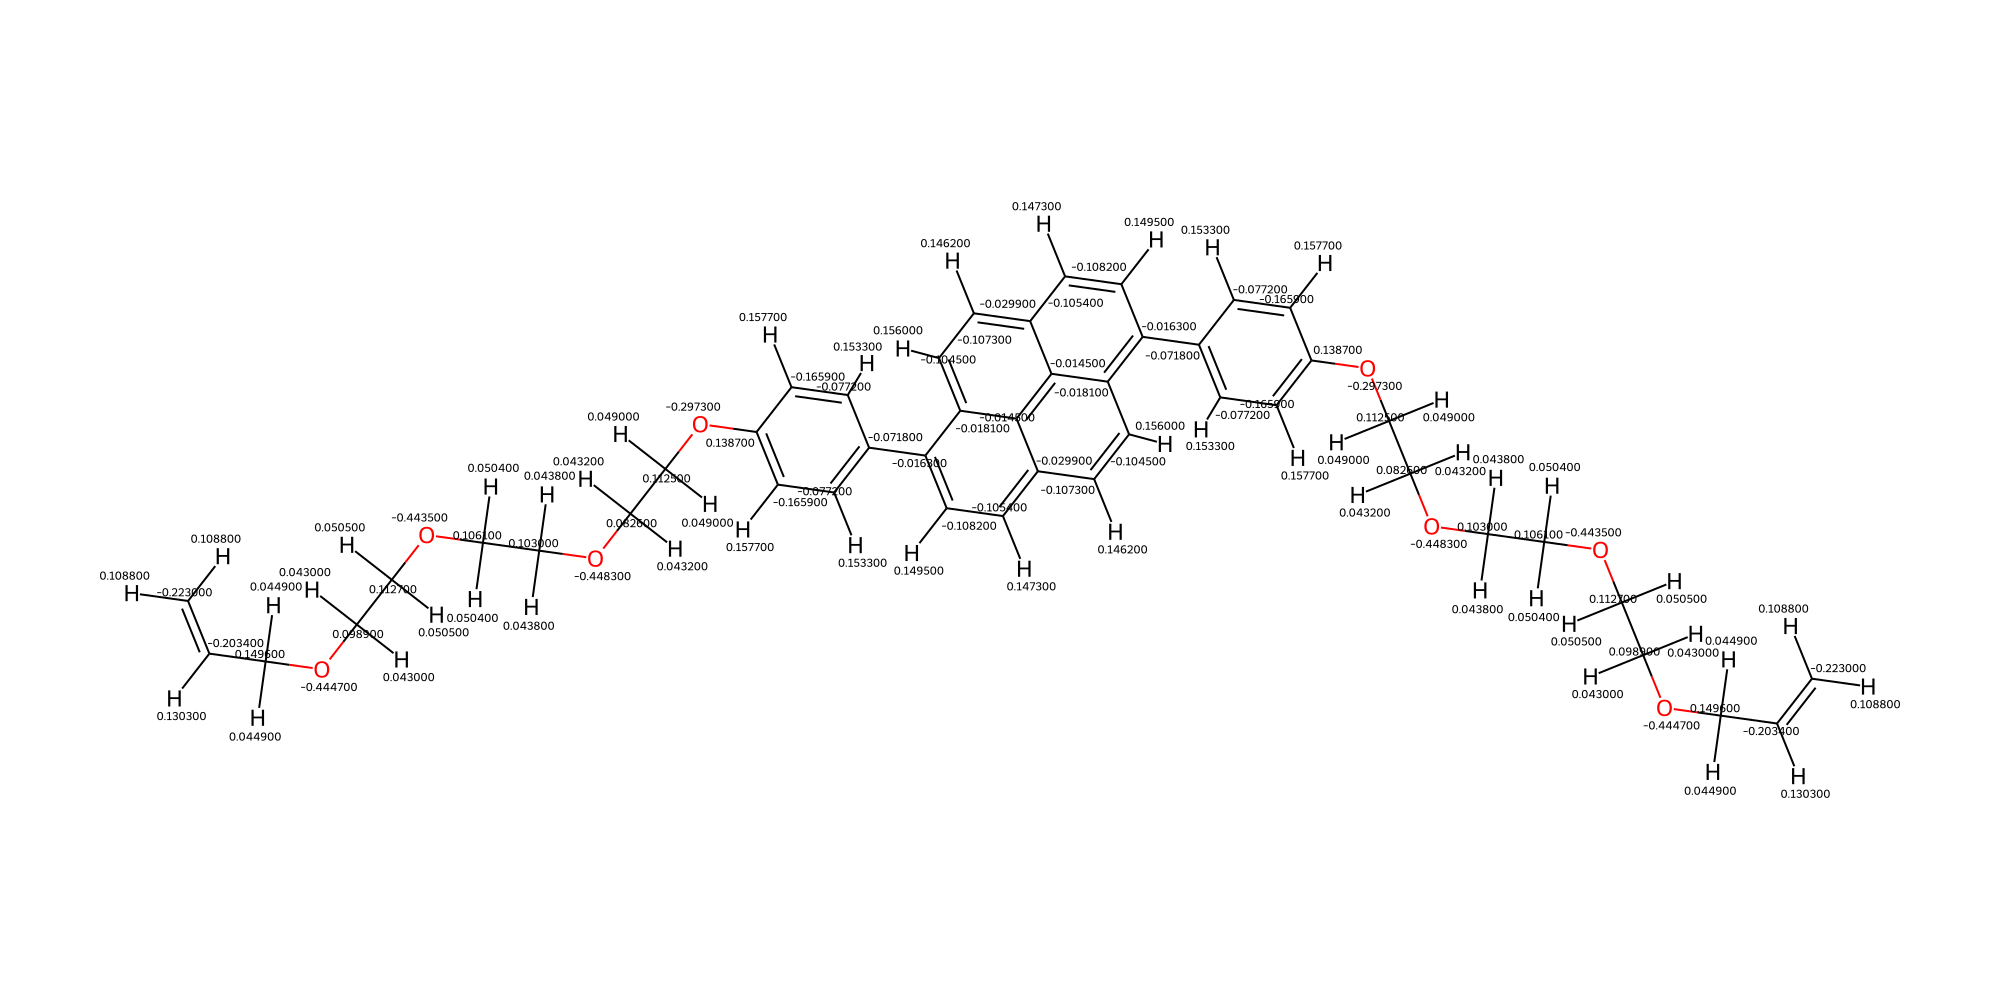

In [8]:
charge = util.read_mol2_charge(os.path.join("build_molecules","motif.mol2"))
motif = AllChem.MolFromPDBFile(os.path.join("build_molecules","motif.pdb"), removeHs=False)
template = AllChem.MolFromSmiles(motif_smiles(nEO))
template = AllChem.AddHs(template)
motif = AllChem.AssignBondOrdersFromTemplate(template, motif)

motif_charge = AllChem.Mol(motif)
AllChem.Compute2DCoords(motif_charge)
for atom in motif_charge.GetAtoms():
    atom.SetProp("_TriposPartialCharge", "%f" % charge[(atom.GetIdx()+1,atom.GetMonomerInfo().GetName().strip())])
    lbl = atom.GetProp("_TriposPartialCharge")
    atom.SetProp('atomNote',lbl)
    #atom.SetProp("molAtomMapNumber", str(atom.GetIdx()+1))
img = AllChem.Draw.MolsToGridImage([motif_charge], molsPerRow=1, subImgSize=[2000,1000])
img

[00:54:55] WARNING: More than one matching pattern found - picking one



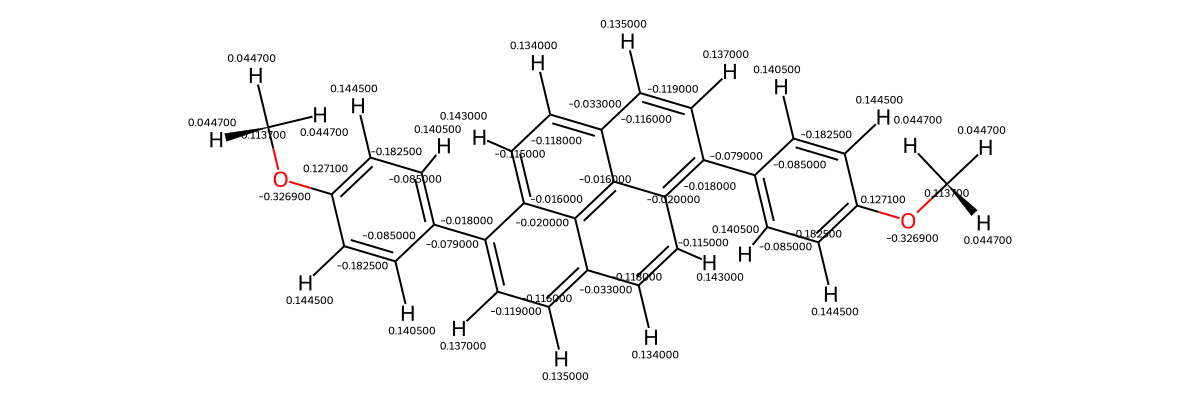

In [9]:
core_smiles = "COc6ccc(c2ccc3ccc5c(c1ccc(OC)cc1)ccc4ccc2c3c45)cc6"

charge = util.read_mol2_charge(os.path.join("build_molecules", "core", "amber_charge", "confId0.mol2"))
core = AllChem.MolFromPDBFile(os.path.join("build_molecules", "core", "amber_charge", "confId0.pdb"), removeHs=False)
template = AllChem.MolFromSmiles(core_smiles)
template = AllChem.AddHs(template)
core = AllChem.AssignBondOrdersFromTemplate(template, core)

core_charge = AllChem.Mol(core)
AllChem.Compute2DCoords(core_charge)
for atom in core_charge.GetAtoms():
    atom.SetProp("_TriposPartialCharge", "%f" % charge[(atom.GetIdx()+1,atom.GetMonomerInfo().GetName().strip())])
    lbl = atom.GetProp("_TriposPartialCharge")
    atom.SetProp('atomNote',lbl)
    #atom.SetProp("molAtomMapNumber", str(atom.GetIdx()+1))
img = AllChem.Draw.MolsToGridImage([core_charge], molsPerRow=1, subImgSize=[1200,400])
img

[00:54:55] WARNING: More than one matching pattern found - picking one



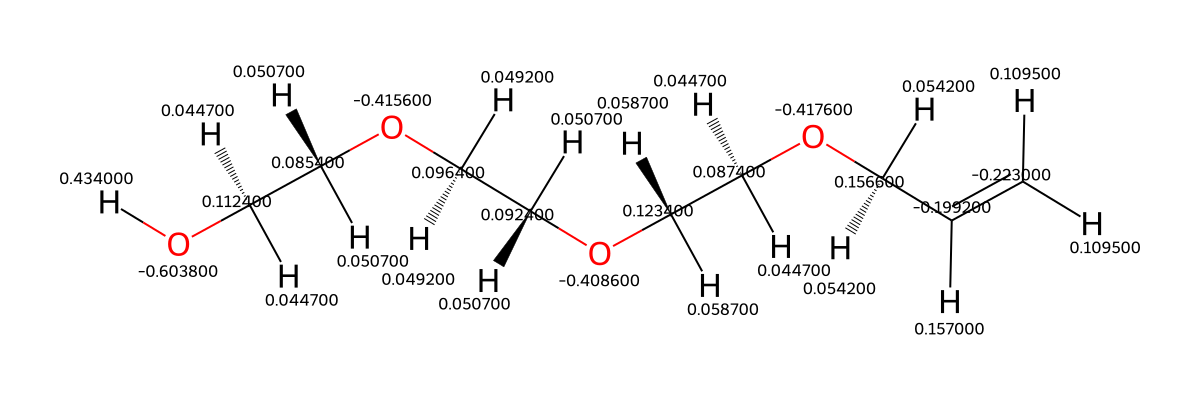

In [10]:
tail_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "O"

charge = util.read_mol2_charge(os.path.join("build_molecules", "tail", "amber_charge", "confId0.mol2"))
tail = AllChem.MolFromPDBFile(os.path.join("build_molecules", "tail", "amber_charge", "confId0.pdb"), removeHs=False)
template = AllChem.MolFromSmiles(tail_smiles(3))
template = AllChem.AddHs(template)
tail = AllChem.AssignBondOrdersFromTemplate(template, tail)

tail_charge = AllChem.Mol(tail)
AllChem.Compute2DCoords(tail_charge)
for atom in tail_charge.GetAtoms():
    atom.SetProp("_TriposPartialCharge", "%f" % charge[(atom.GetIdx()+1,atom.GetMonomerInfo().GetName().strip())])
    lbl = atom.GetProp("_TriposPartialCharge")
    atom.SetProp('atomNote',lbl)
    #atom.SetProp("molAtomMapNumber", str(atom.GetIdx()+1))
img = AllChem.Draw.MolsToGridImage([tail_charge], molsPerRow=1, subImgSize=[1200,400])
img

# Compare atomic partial charge calculated by different methods

Find the atmo-to-atom matching between two rdkit molecules

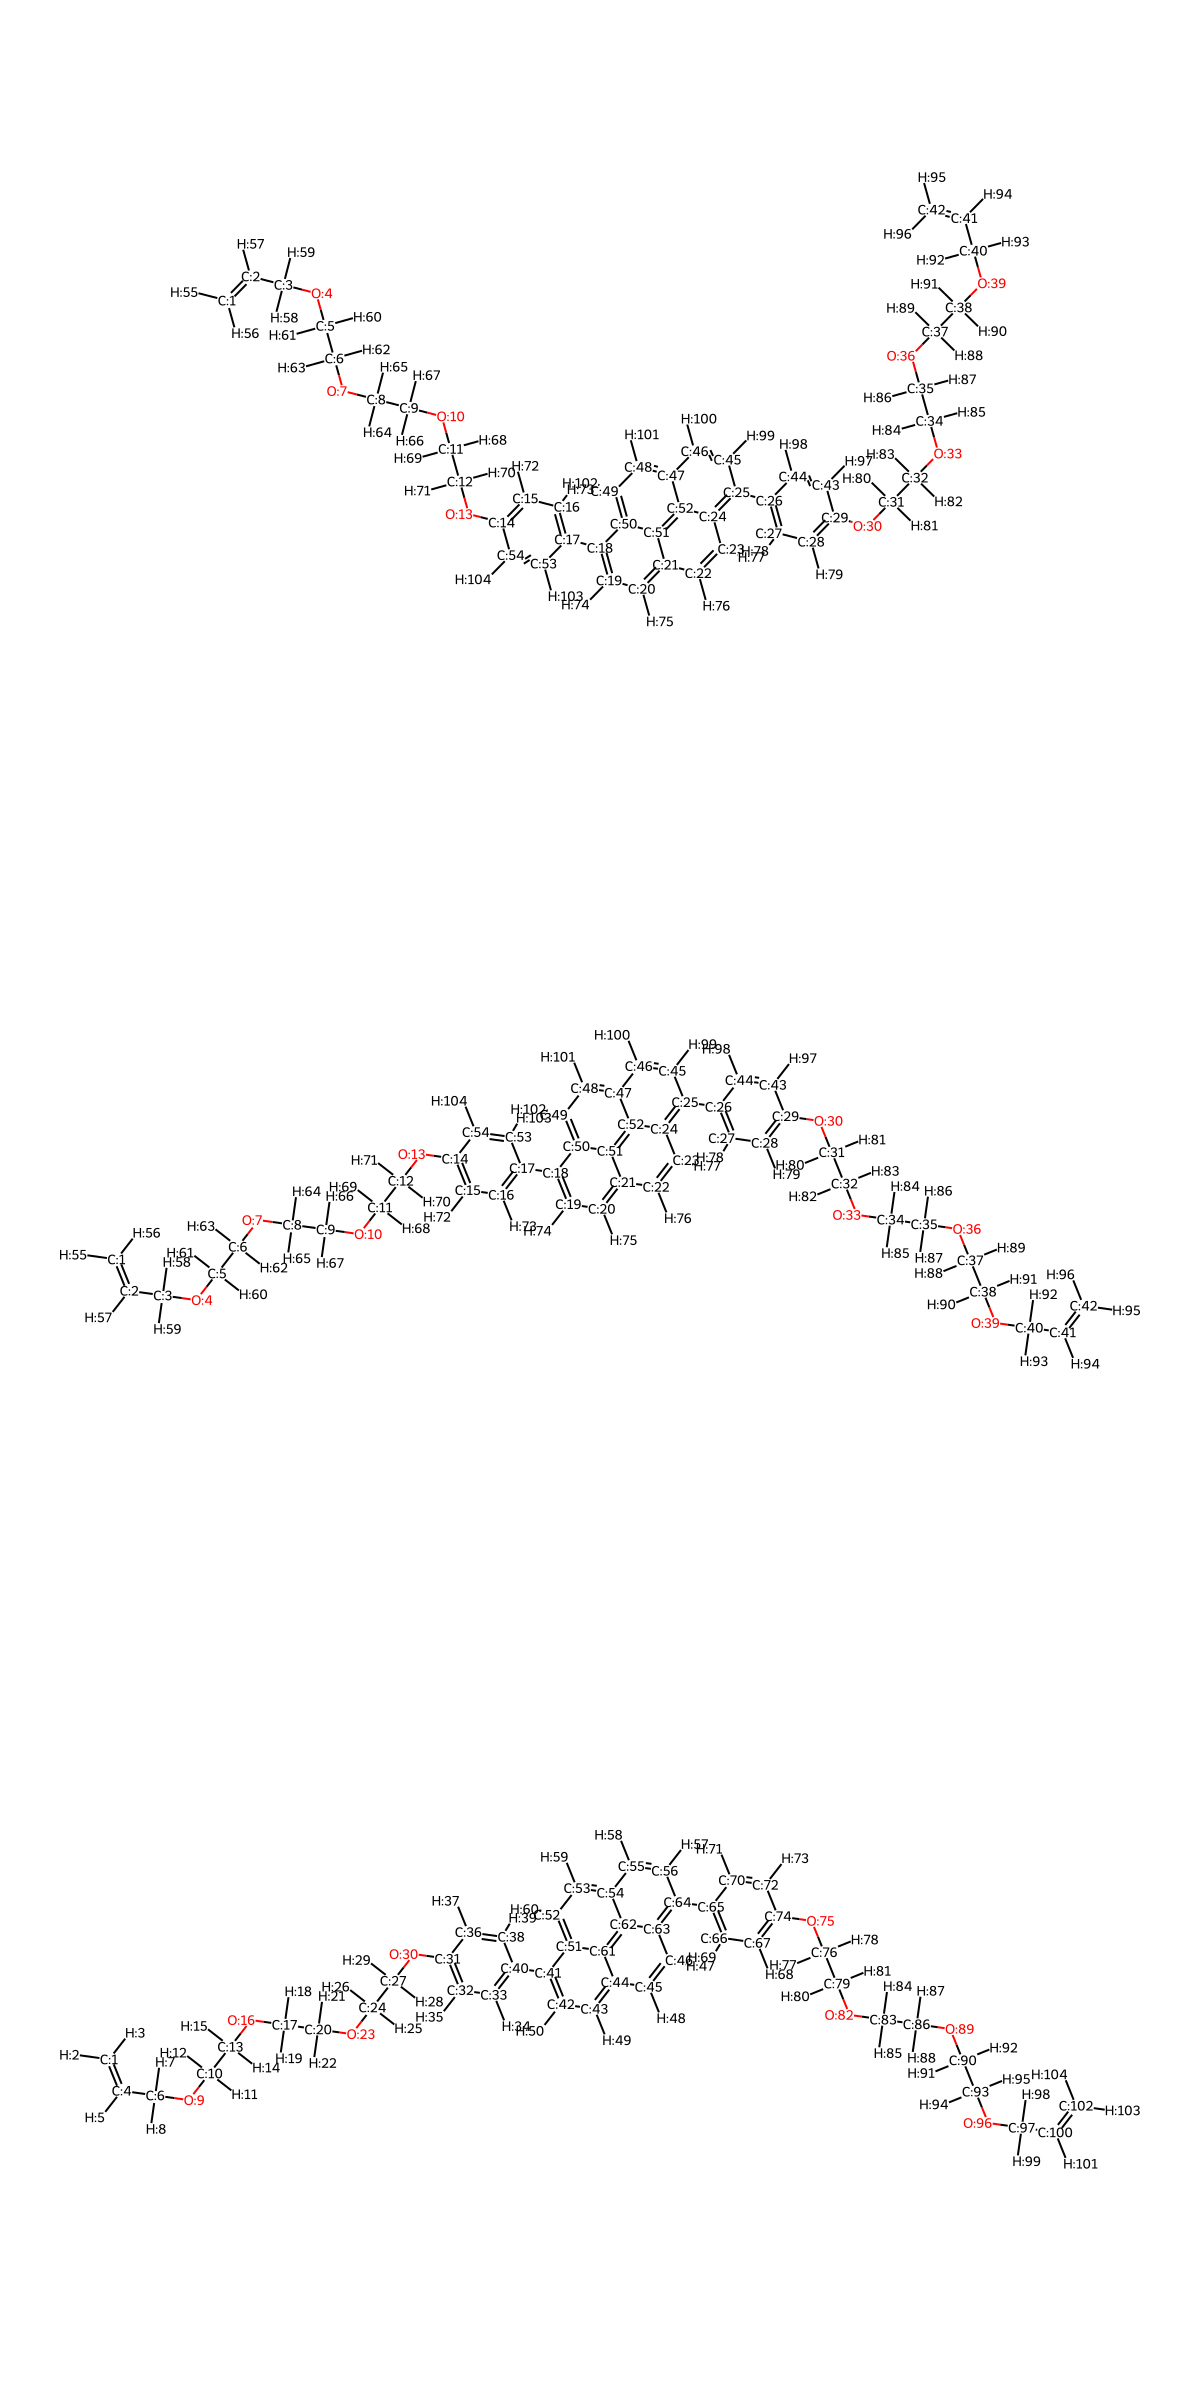

In [11]:
def addAtomIndices(mol):
    for i, a in enumerate(mol.GetAtoms()):
        a.SetAtomMapNum(i+1)

chg_mol = AllChem.Mol(chg.mol)
AllChem.Compute2DCoords(chg_mol)
AllChem.Compute2DCoords(motif)
new_order = motif.GetSubstructMatch(chg_mol)
motif_renum = AllChem.RenumberAtoms(motif, new_order)
addAtomIndices(chg_mol)
addAtomIndices(motif)    # before atom-to-atom matching
addAtomIndices(motif_renum)    # after atom-to-atom matching
img = AllChem.Draw.MolsToGridImage((chg_mol, motif_renum, motif), molsPerRow=1, subImgSize=(1200,800))
img

Comparing partial charge obtained by two different methods, atom-by-atom

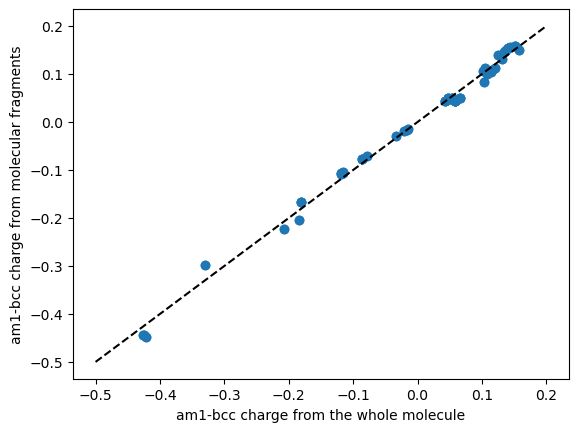

In [12]:
new_order = motif_charge.GetSubstructMatch(chg.mol_charge)
motif_renum = AllChem.RenumberAtoms(motif_charge, new_order)
addAtomIndices(motif_charge)

fig, ax = plt.subplots(1)
charge_mol1 = []
charge_mol2 = []
for atom in chg.mol_charge.GetAtoms():
    q = float(atom.GetProp("_TriposPartialCharge"))
    charge_mol1.append(q)
for atom in motif_renum.GetAtoms():
    q = float(atom.GetProp("_TriposPartialCharge"))
    charge_mol2.append(q)
ax.plot(charge_mol1, charge_mol2, ls='none', marker='o')
ax.plot([-0.5, 0.2], [-0.5, 0.2], 'k--')
ax.set_xlabel('am1-bcc charge from the whole molecule')
ax.set_ylabel('am1-bcc charge from molecular fragments')
plt.show()